In [3]:
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights, ResNet18_Weights, resnet18, EfficientNet_B0_Weights, efficientnet_b0
import random
import torch
class SiameseResNet(nn.Module):
    def __init__(self):
        super(SiameseResNet, self).__init__()


        self.resnet50  = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        ct = 0
        for child in self.resnet50.children():
            ct += 1
            if ct < 9:
                for param in child.parameters():
                    param.requires_grad = False

        blocks = list(self.resnet50.layer4.children())[-2]

        for param in blocks.parameters():
                param.requires_grad = True
        # Remove the final layer to get embeddings
        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])

        self.dense = nn.Sequential(
            nn.Linear(2048, 1048),
            nn.BatchNorm1d(1048),
            nn.ReLU(),
            nn.Linear(1048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
        )



    def forward_one(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.dense(x)
        return x

    def forward(self, anchor, positive, negative):
        anchor_embedding = self.forward_one(anchor)
        positive_embedding = self.forward_one(positive)
        negative_embedding = self.forward_one(negative)
        return anchor_embedding, positive_embedding, negative_embedding

In [4]:
def check_frozen(model):
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"Module {name} is frozen")
        else:
            print(f"Module {name} is NOT frozen")

# example usage:
model = SiameseResNet()
check_frozen(model)

Module resnet50.conv1.weight is frozen
Module resnet50.bn1.weight is frozen
Module resnet50.bn1.bias is frozen
Module resnet50.layer1.0.conv1.weight is frozen
Module resnet50.layer1.0.bn1.weight is frozen
Module resnet50.layer1.0.bn1.bias is frozen
Module resnet50.layer1.0.conv2.weight is frozen
Module resnet50.layer1.0.bn2.weight is frozen
Module resnet50.layer1.0.bn2.bias is frozen
Module resnet50.layer1.0.conv3.weight is frozen
Module resnet50.layer1.0.bn3.weight is frozen
Module resnet50.layer1.0.bn3.bias is frozen
Module resnet50.layer1.0.downsample.0.weight is frozen
Module resnet50.layer1.0.downsample.1.weight is frozen
Module resnet50.layer1.0.downsample.1.bias is frozen
Module resnet50.layer1.1.conv1.weight is frozen
Module resnet50.layer1.1.bn1.weight is frozen
Module resnet50.layer1.1.bn1.bias is frozen
Module resnet50.layer1.1.conv2.weight is frozen
Module resnet50.layer1.1.bn2.weight is frozen
Module resnet50.layer1.1.bn2.bias is frozen
Module resnet50.layer1.1.conv3.weigh

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
pair_train = pd.read_csv('pair.csv')
anchors = []
positives = []
negatives = []
for index, row in pair_train.iterrows():
    for negative in row[2:]:
        anchors.append(row[0])
        positives.append(row[1])
        negatives.append(negative)
# Combine the lists into a single list of tuples
data = list(zip(anchors, positives, negatives))

# Split the combined list into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Separate the training and validation sets into anchors, positives, and negatives
train_anchors, train_positives, train_negatives = zip(*train_data)
val_anchors, val_positives, val_negatives = zip(*val_data)


In [8]:

class ImageTripletDataset(Dataset):
    def __init__(self, anchors, positives, negatives, tensor_dict_left, tensor_dict_right, all_keys_right):
        self.anchors = anchors
        self.positives = positives
        self.negatives = negatives
        self.tensor_dict_left = tensor_dict_left
        self.tensor_dict_right = tensor_dict_right
        self.all_keys_right = all_keys_right


    def __getitem__(self, idx):
        anchor = self.tensor_dict_left[self.anchors[idx]]
        positive = self.tensor_dict_right[self.positives[idx]]

        if random.random() < 0.5:
            possible_keys = self.all_keys_right.copy()
            possible_keys.remove(self.positives[idx])
            possible_keys.remove(self.negatives[idx])

            negative = self.tensor_dict_right[random.choice(all_keys_right)]

        else:
            negative = self.tensor_dict_right[self.negatives[idx]]

        return anchor, positive, negative

    def __len__(self):
        return len(self.anchors)


In [9]:
def load_tensors_from_folder(tensor_folder):
    tensor_files = [f for f in os.listdir(tensor_folder) if f.endswith('.pt')]
    tensor_dict = {}

    for tensor_file in tensor_files:
        tensor_path = os.path.join(tensor_folder, tensor_file)
        tensor_name = os.path.splitext(tensor_file)[0]  # Remove the .pt extension
        tensor_dict[tensor_name] = torch.load(tensor_path)

    return tensor_dict

# Usage example
tensor_folder_left = '/content/tensor/train_tensor_res50/left'
tensor_dict_left = load_tensors_from_folder(tensor_folder_left)
tensor_folder_right = '/content/tensor/train_tensor_res50/right'
tensor_dict_right = load_tensors_from_folder(tensor_folder_right)
all_keys_right =  list(tensor_dict_right.keys())

In [23]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
device = torch.device('cuda')
model = SiameseResNet().to(device)
criterion = nn.TripletMarginLoss(margin=1, p=2, eps=1e-7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_data_loader = DataLoader(ImageTripletDataset(train_anchors, train_positives, train_negatives, tensor_dict_left, tensor_dict_right, all_keys_right), batch_size=64, shuffle=True)
val_data_loader = DataLoader(ImageTripletDataset(val_anchors, val_positives, val_negatives, tensor_dict_left, tensor_dict_right, all_keys_right), batch_size=64, shuffle=False)

In [24]:
num_epochs = 15
patience = 2
best_loss = float('inf')
epochs_without_improvement = 0
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", position=0, leave=True)

    for anchor, positive, negative in progress_bar:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_embed, positive_embed, negative_embed = model(anchor, positive, negative)
        loss = criterion(anchor_embed, positive_embed, negative_embed)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": epoch_loss / (progress_bar.n + 1)})

    avg_epoch_loss = epoch_loss / len(train_data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss}")
    train_losses.append(avg_epoch_loss)
    # Validation
    model.eval()


    val_loss_temp = []  # Temporary list to store validation batch losses
    with torch.no_grad():
        for anchor, positive, negative in val_data_loader:
            anchor_embed, positive_embed, negative_embed = model(anchor.to(device), positive.to(device), negative.to(device))
            loss_val = criterion(anchor_embed, positive_embed, negative_embed)
            val_loss_temp.append(loss_val.item())

    val_loss = sum(val_loss_temp) / len(val_loss_temp)
    val_losses.append(val_loss)  # Append average validation loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss}")
    if val_loss  < best_loss:
        best_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'fine_tuned_model_new.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping due to no improvement in training loss.")
        break

    model.train()  # Set model back to training mode for next epoch






Epoch 1/15: 100%|██████████| 475/475 [02:30<00:00,  3.16it/s, loss=0.166]


Epoch 1/15, Average Loss: 0.16567709845931908
Epoch 1/15, Validation Loss: 0.01611216341247078


Epoch 2/15: 100%|██████████| 475/475 [02:30<00:00,  3.16it/s, loss=0.0146]


Epoch 2/15, Average Loss: 0.014571411782189419
Epoch 2/15, Validation Loss: 0.009293794968486334


Epoch 3/15: 100%|██████████| 475/475 [02:30<00:00,  3.15it/s, loss=0.00867]


Epoch 3/15, Average Loss: 0.008669141076113048
Epoch 3/15, Validation Loss: 0.008325280073811026


Epoch 4/15: 100%|██████████| 475/475 [02:29<00:00,  3.19it/s, loss=0.00879]


Epoch 4/15, Average Loss: 0.008789045951868359
Epoch 4/15, Validation Loss: 0.010811668171101258


Epoch 5/15: 100%|██████████| 475/475 [02:30<00:00,  3.17it/s, loss=0.00796]


Epoch 5/15, Average Loss: 0.00796019993330303
Epoch 5/15, Validation Loss: 0.007354357725932819


Epoch 6/15: 100%|██████████| 475/475 [02:29<00:00,  3.18it/s, loss=0.00755]


Epoch 6/15, Average Loss: 0.007550905425297586
Epoch 6/15, Validation Loss: 0.012035262778777034


Epoch 7/15: 100%|██████████| 475/475 [02:29<00:00,  3.17it/s, loss=0.00763]


Epoch 7/15, Average Loss: 0.0076311899172632315
Epoch 7/15, Validation Loss: 0.01083859582157696
Early stopping due to no improvement in training loss.


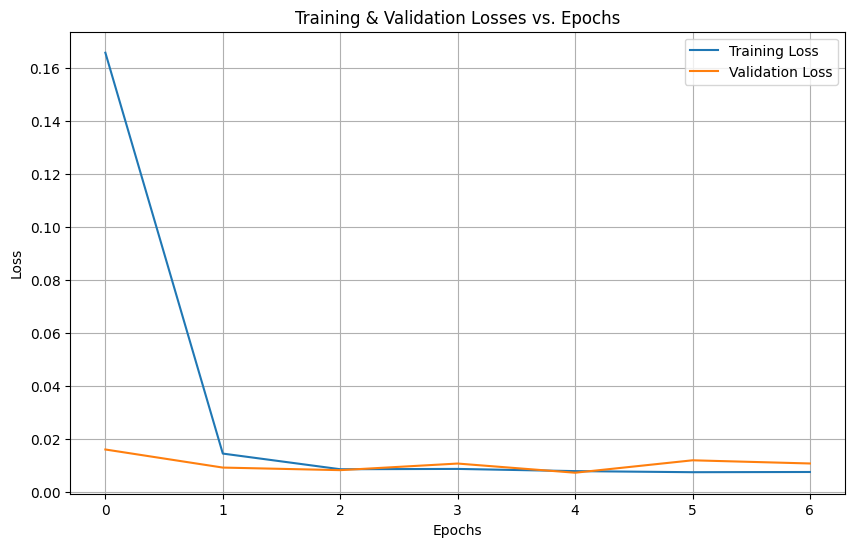

In [29]:
import matplotlib.pyplot as plt
epochs = list(range(len(train_losses)))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Losses vs. Epochs')
plt.legend()
plt.grid(True)
plt.xticks(epochs)  # Set x-ticks to be the epoch numbers
plt.show()